# Forward Collars
Price forward collars using different models. Forward collars are insightful because

- they are sensitive to the forward skew of the implied volatility surface, and therefore highlight the forward vol dynamics of each model.
- a cliquet can be thought of as a series of forward collars.

In [24]:
from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow as pa
from matplotlib import pyplot as plt
from qablet.black_scholes.mc import LVMCModel
from qablet.heston.mc import HestonMCModel
from qablet_contracts.timetable import TS_EVENT_SCHEMA

from data.spx_2005_09_15 import (
    heston_data,
    localvol_data,
    rbergomi_data,
    basic_info,
)
from src.model.rbergomi import rBergomiMCModel

In [25]:
# We will compare everything with the SVI implied volatilities on 2005-09-15
info = basic_info()
prc_dt = info["prc_dt"]
ticker = info["ticker"]
spot = info["spot"]

# We will use a collar width of 1%
width = 0.01 * spot

### Forward Collars
Forward collars are not in the qablet_contracts package. We will write a method to create forward collars here, using the [qablet specifications](https://qablet.github.io/qablet-contracts/specifications/timetable/). Forward collar has two events

- set the strike, at a future strike time, using a given strike_rate
- pay at maturity, based on above strike, and a collar width.

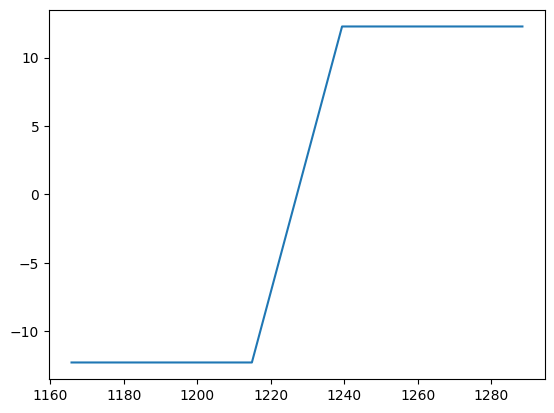

In [26]:
# Define collar phrase, which is spot - K, capped and floored.
# Unlike the previous notebook, it takes two inputs as the strikes are not fixed.
def collar_pay_fn(inputs):
    [s, k] = inputs

    ret = np.maximum(-width, s - k)
    ret = np.minimum(width, ret)

    return [ret]


# Plot the payoff using current spot as the strike
strike = spot
s_vec = np.linspace(strike - 0.05 * spot, strike + 0.05 * spot, 11)
pay_vec = collar_pay_fn([s_vec, strike])
plt.plot(s_vec, pay_vec[0])

In [27]:
# Create a Collar
def fwd_collar_timetable(ticker, strike_rate, width, strike_time, maturity):
    events = [
        {
            "track": None,
            "time": strike_time,
            "op": None,
            "quantity": 0,
            "unit": "FIX",  # set strike
        },
        {
            "track": "",
            "time": maturity,
            "op": "+",
            "quantity": 1,
            "unit": "COLLAR",  # pay collar
        },
    ]

    # Define the strike phrase, which is the spot times strike rate.
    def strike_fn(inputs):
        [s] = inputs
        return [s * strike_rate]

    events_table = pa.RecordBatch.from_pylist(events, schema=TS_EVENT_SCHEMA)
    return {
        "events": events_table,
        "expressions": {
            "COLLAR": {
                "type": "phrase",
                "inp": [ticker, "K"],  # must match no of inputs in fn
                "fn": collar_pay_fn,
            },
            "FIX": {
                "type": "snapper",
                "inp": [ticker],
                "fn": strike_fn,
                "out": ["K"],
            },
        },
    }


# Try an example:
timetable = fwd_collar_timetable(
    ticker, 1.0, width, datetime(2013, 10, 31), datetime(2013, 12, 31)
)
print(timetable["events"].to_pandas())

  track                      time   op  quantity    unit
0   NaN 2013-10-31 00:00:00+00:00  NaN       0.0     FIX
1       2013-12-31 00:00:00+00:00    +       1.0  COLLAR


Create a series of forward collars starting at different expiration dates, setting strikes two months prior to expiration.

In [29]:
fix_dates = [prc_dt]
exp_dates = []
timetables = []

for i in range(6):
    exp_dt = prc_dt + pd.DateOffset(months=2 * i + 2)
    exp_dates.append(exp_dt)
    fix_dates.append(exp_dt)  # applies to next period
    timetables.append(
        fwd_collar_timetable(
            ticker,
            strike_rate=1.0,
            width=width,
            strike_time=fix_dates[i],
            maturity=exp_dates[i],
        )
    )
df = pd.DataFrame({"fix date": fix_dates[:-1], "exp date": exp_dates})
df

,fix date,exp date
0,2005-09-14,2005-11-14
1,2005-11-14,2006-01-14
2,2006-01-14,2006-03-14
3,2006-03-14,2006-05-14
4,2006-05-14,2006-07-14
5,2006-07-14,2006-09-14


### Compare Models
Compare different models, starting with Local Volatility Model.

In [30]:
model = LVMCModel()

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, localvol_data())
    prices.append(price)

df["LocalVol"] = prices
df

,fix date,exp date,LocalVol
0,2005-09-14,2005-11-14,2.603245
1,2005-11-14,2006-01-14,1.577387
2,2006-01-14,2006-03-14,1.337892
3,2006-03-14,2006-05-14,1.221289
4,2006-05-14,2006-07-14,1.114165
5,2006-07-14,2006-09-14,0.898284


Heston Model

In [31]:
model = HestonMCModel()

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, heston_data())
    prices.append(price)
df["Heston"] = prices
df

,fix date,exp date,LocalVol,Heston
0,2005-09-14,2005-11-14,2.603245,2.154498
1,2005-11-14,2006-01-14,1.577387,2.382918
2,2006-01-14,2006-03-14,1.337892,2.301607
3,2006-03-14,2006-05-14,1.221289,2.334131
4,2006-05-14,2006-07-14,1.114165,2.193293
5,2006-07-14,2006-09-14,0.898284,2.162660


Bergomi Model

In [32]:
model = rBergomiMCModel()
dataset = rbergomi_data()
dataset["MC"]["PATHS"] = 20_000  # very slow with 100_000, 1/250
dataset["MC"]["TIMESTEP"] = 1 / 100

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, dataset)
    prices.append(price)
df["rBergomi"] = prices
df

,fix date,exp date,LocalVol,Heston,rBergomi
0,2005-09-14,2005-11-14,2.603245,2.154498,2.605350
1,2005-11-14,2006-01-14,1.577387,2.382918,2.759082
2,2006-01-14,2006-03-14,1.337892,2.301607,2.569883
3,2006-03-14,2006-05-14,1.221289,2.334131,2.712798
4,2006-05-14,2006-07-14,1.114165,2.193293,2.721521
5,2006-07-14,2006-09-14,0.898284,2.162660,2.619573


## Plot

<Axes: title={'center': 'Forward Collar Prices'}, xlabel='exp date'>

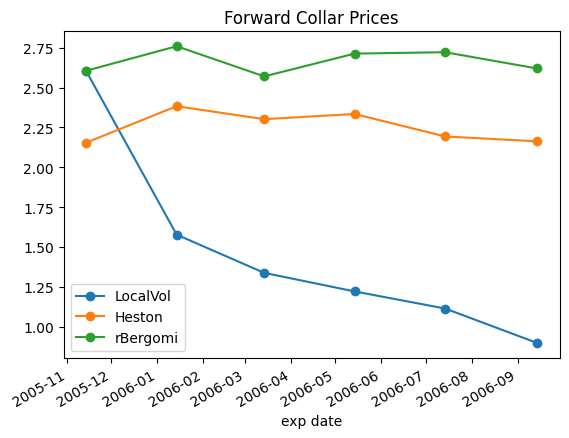

In [33]:
df.columns
df.plot(
    x="exp date",
    y=["LocalVol", "Heston", "rBergomi"],
    marker="o",
    title="Forward Collar Prices",
)

For the first expiration, the strike sets at the pricing date, therefore they are exactly the same contract as the vanilla collars in the previous notebook. They match, except Heston.

For later expirations, the local volatility model significantly underprices the collars relative to the others.